# RA2CE feature: Hazard overlay

In this notebook, we will guide you through performing a hazard overlay with a network using RA2CE.
This notebook follows the RA2CE_basics notebook, in which the user creates a network from OSM. 
This is needed first before being able to execute this notebook

First of all, we will import the packages we need to execute the notebook:

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio

c:\Users\asgarpou\AppData\Local\miniconda3\envs\ra2ce_env\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


Import RA2CE by importing the RA2CEHandler

In [2]:
from ra2ce.ra2ce_handler import Ra2ceHandler # import the ra2cehandler to run ra2ce analyses

Specify the path to the folder holding your input data and where you want to store your output (use the RA2CE folder structure!)

In [5]:
root_dir = Path (r'.\\data\\hazard_overlay') #specify the path to the folder holding the RA2CE folder and input data

Specify the names of the initialization files and check whether they exist and can be found

In [6]:
_network_ini_name = "network.ini" #set the name for the network.ini
_analyses_ini_name = "analyses.ini" #set the name for the analyses.ini

network_ini = root_dir / _network_ini_name
analyses_ini = root_dir / _analyses_ini_name

assert network_ini.is_file() # check whether the network.ini file exists
assert analyses_ini.is_file() # check whether the analyses.ini file exists

## Hazard map
Now we need a hazard map! 
You can use any hazard map, as long as it is in .tif format and you specify the correct projection in the network.ini file.

Save the map in the static/hazard folder. If you are not familiar with the RA2CE folder structure, first open the ra2ce_basics notebook.

*You can for example download flood maps from the Global Flood Database.*

*Note: the hazard map needs to be in **.tif** format*

In [7]:
hazard_folder = root_dir / "static" / "hazard" # find the hazard folder where you locate your hazard map
hazard_map = hazard_folder / "max_flood_depth.tif" # set the name of the hazard map

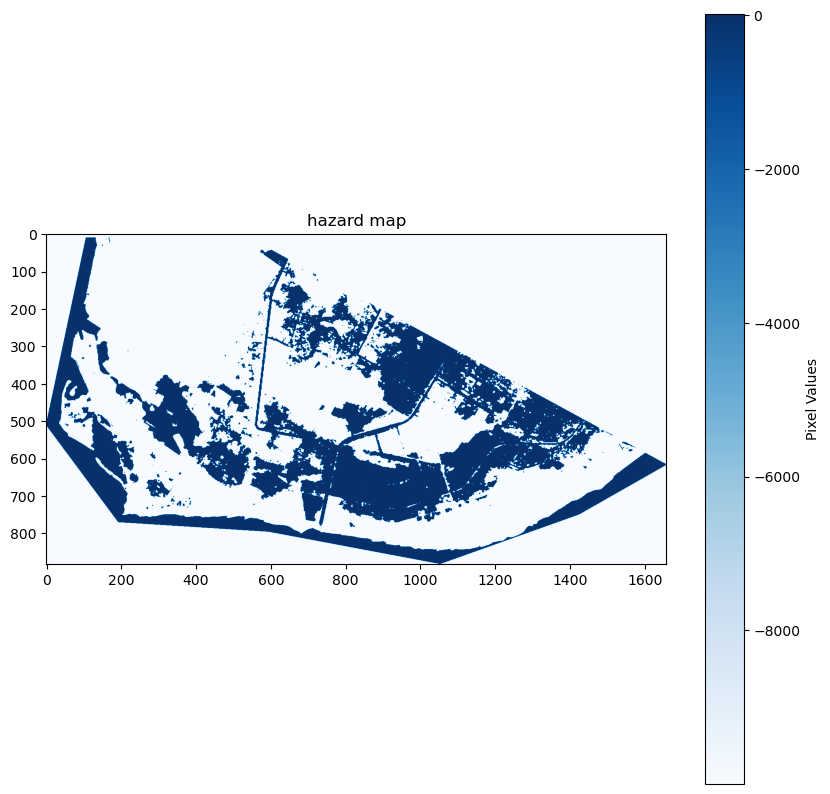

In [8]:
# Open the TIF file using rasterio
with rasterio.open(hazard_map) as src:
    # Read the TIF file as a numpy array
    tif_array = src.read(1)  # Change the band index (1) if necessary

plt.figure(figsize=(10, 10))
plt.imshow(tif_array, cmap='Blues')  # Change the colormap if desired
plt.colorbar(label='Pixel Values')
plt.title('hazard map')
plt.show()  


## Network.ini file

To use the hazard map with RA2CE, we need to fill in the **[hazard]** section in the network.ini. 

Specify the hazard map name in the **hazard_map** parameter in network.ini. RA2CE expects the hazard map to be located in the *hazard* folder. 

Set the right CRS for the hazard map in the **hazard_crs** parameter. This CRS can be different from that of origins, destinations and the network. RA2CE will reproject the network to the CRS of the flood map and will reproject the network back to the original CRS when the CRS differs.

*Advanced: If you have a hazard map with continous scale variables, the **aggregate_wl** parameter in analysis.ini can be set to either 'max', 'min' or 'mean' to take the maximum, minimum or mean value per network segment when the exposure of the network to a certain hazard (map) is determined.*<br>

**Network.ini content**
<br>
<br>
> [project]<br>
name = *project name*<br>
<br>
[network]<br>
directed = False<br>
source = OSM download<br>
primary_file = None<br>
diversion_file = None<br>
file_id = rfid_c<br>
polygon = map.geojson<br>
network_type = drive<br>
road_types = motorway,motorway_link,primary,primary_link,secondary,secondary_link,tertiary,tertiary_link<br>
save_gpkg = True<br>
<br>
[origins_destinations]<br>
origins = None<br>
destinations = None<br>
origins_names = None<br>
destinations_names = None<br>
id_name_origin_destination = None<br>
origin_count = None<br>                         
origin_out_fraction = None<br>
category = None<br>
<br>
[hazard]<br>
**hazard_map = max_flood_depth.tif**<br>
hazard_id = None<br>
hazard_field_name = waterdepth<br>
**aggregate_wl = max**<br>
**hazard_crs = EPSG:32736**<br>
<br>
*[cleanup]<br>
snapping_threshold = None<br>
segmentation_length = None<br>
merge_lines = True<br>
merge_on_id = False<br>
cut_at_intersections = False<br>*


## Run RA2CE

Now, run RA2CE using the network.ini

In [9]:
handler = Ra2ceHandler(network=network_ini, analysis=None)
handler.configure()

2023-11-02 12:06:05 PM - [ra2ce_logging.py:41] - root - INFO - RA2CE logger initialized.
2023-11-02 12:06:05 PM - [network_config_wrapper.py:106] - root - INFO - Existing graph/network found: C:\repos\ra2ce\examples\data\hazard_overlay\static\output_graph\base_graph.p.
2023-11-02 12:06:05 PM - [network_config_wrapper.py:106] - root - INFO - Existing graph/network found: C:\repos\ra2ce\examples\data\hazard_overlay\static\output_graph\base_network.feather.
2023-11-02 12:06:05 PM - [network_config_wrapper.py:106] - root - INFO - Existing graph/network found: C:\repos\ra2ce\examples\data\hazard_overlay\static\output_graph\base_graph_hazard.p.
2023-11-02 12:06:05 PM - [networks.py:183] - root - INFO - Apparently, you already did create a network with ra2ce earlier. Ra2ce will use this: C:\repos\ra2ce\examples\data\hazard_overlay\static\output_graph\base_graph.p
2023-11-02 12:06:05 PM - [hazard.py:89] - root - INFO - Initialized hazard object.
2023-11-02 12:06:05 PM - [hazard.py:995] - root 

DriverError: C:\repos\ra2ce\examples\data\hazard_overlay\static\network: Permission denied

## Results

You can run a RA2CE analysis only performing a hazard overlay. The results can be found in the output_graph folder. The data with *'\*_hazard'*, contains the result of the overlay with the hazard. Here, we will load the data from the example graph folder. 

Notice the column **EV1_ma**. This refers to the hazard. This column holds the water depth of the road segment. 'EV1' stands for 'Event 1' (you can run multiple hzard maps, the column results will be called EV1, EV2, EV3, etc.). '_ma' refers to maximum flood depth, which is the parameter specified in the network.ini. 

*When performing RA2CE with flooding and a road network, we often use the maximum water depth for the analysis because a vehicle can only use a road segment when it can drive through the largest water depth on that road segment.*

*Note: when there is an existing base_graph in the output_graph folder, RA2CE will always use this. However, it can be that you want to update something to that base_graph. In that case, you first have to remove the graph from the folder manually before rerunning.* 

In [ ]:
hazard_output = root_dir / "static" / "output_graph" / "base_graph_hazard_edges.gpkg"
hazard_gdf = gpd.read_file(hazard_output, driver = "GPKG")
hazard_gdf.head()

Let's inspect the results visually. Below, we show the hazard values on the network. A value of 0 indicates no hazard intersection.

In [ ]:
hazard_gdf.explore(column="EV1_ma", cmap = "Reds")